## ACEA Smart Water Analytics using Time Series Forecasting

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this project I want to deep dive into TimeSeries analysis to show how to review the data, how to preview it and how to engineering.

I also want to explore some of the typical TimeSeries topics such as:

ACF/PACF

ARIMA

Auto-ARIMA

Augmented Dickey-Fuller (ADF)

## Table of Contents:

<b> 1. Data Visualisation
    
<b> 2. Data Preprocessing
    
        2.1 Handle Missing Values
        2.2 Smoothing data/Resampling
        2.3 Stationarity
            2.3.1 Augmented Dickey Fuller(ADF)
            2.3.2 Transforming
            2.3.3 Differencing
    
<b> 3. Feature Engineering
    
        3.1 Encoding Cyclical Features
        3.2 Time series Decomposition
        3.3 Lag

<b> 4. Exploratory Data Analysis
    
        4.1 Autocorrelation Analysis
    
<b> 5. Modelling
    
        5.1 Models for univariate time series
            5.1.1 ARIMA
            5.1.2 Auto-ARIMA
            5.1.3 LSTM

### Some points before starting:

<b> Exploratory Data Analysis (EDA):

Before diving into modeling, it's crucial to understand the underlying patterns and trends in our data. We use techniques like rolling statistics and decomposition to identify seasonality, trends, and noise.
    
<b> ACF/PACF Analysis:
    
Auto-correlation function (ACF) and partial auto-correlation function (PACF) plots help determine the order of ARIMA models. ACF shows the correlation between the series and lagged versions of itself, while PACF eliminates the influence of intermediate lags.
    
<b> ARIMA Modeling:
    
ARIMA (AutoRegressive Integrated Moving Average) is a popular time series modeling technique. It consists of three components: AutoRegressive (AR), Integration (I), and Moving Average (MA). We can determine the order of ARIMA through ACF/PACF analysis.

<b> Auto-ARIMA:

Auto-ARIMA is a variation of ARIMA that automatically selects the best parameters (p, d, q) based on AIC (Akaike Information Criterion) or other criteria.
    
<b> Augmented Dickey-Fuller Test (ADF):

The ADF test helps determine if a time series is stationary. Stationarity is important for accurate modeling. If the series is non-stationary, differencing may be required.

In [3]:
df = pd.read_csv("Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [4]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [5]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Since this is a TimeSeries problem, we have to parse 'date' column

In [6]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## 1. Data Visualisation

Features:

* Rainfall indicates the quantity of rain falling (mm)

* Temperature indicates the temperature (°C)

* Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )

* Hydrometry indicates the groundwater level (m)

Target:

* Depth to Groundwater indicates the groundwater level (m from the ground floor)

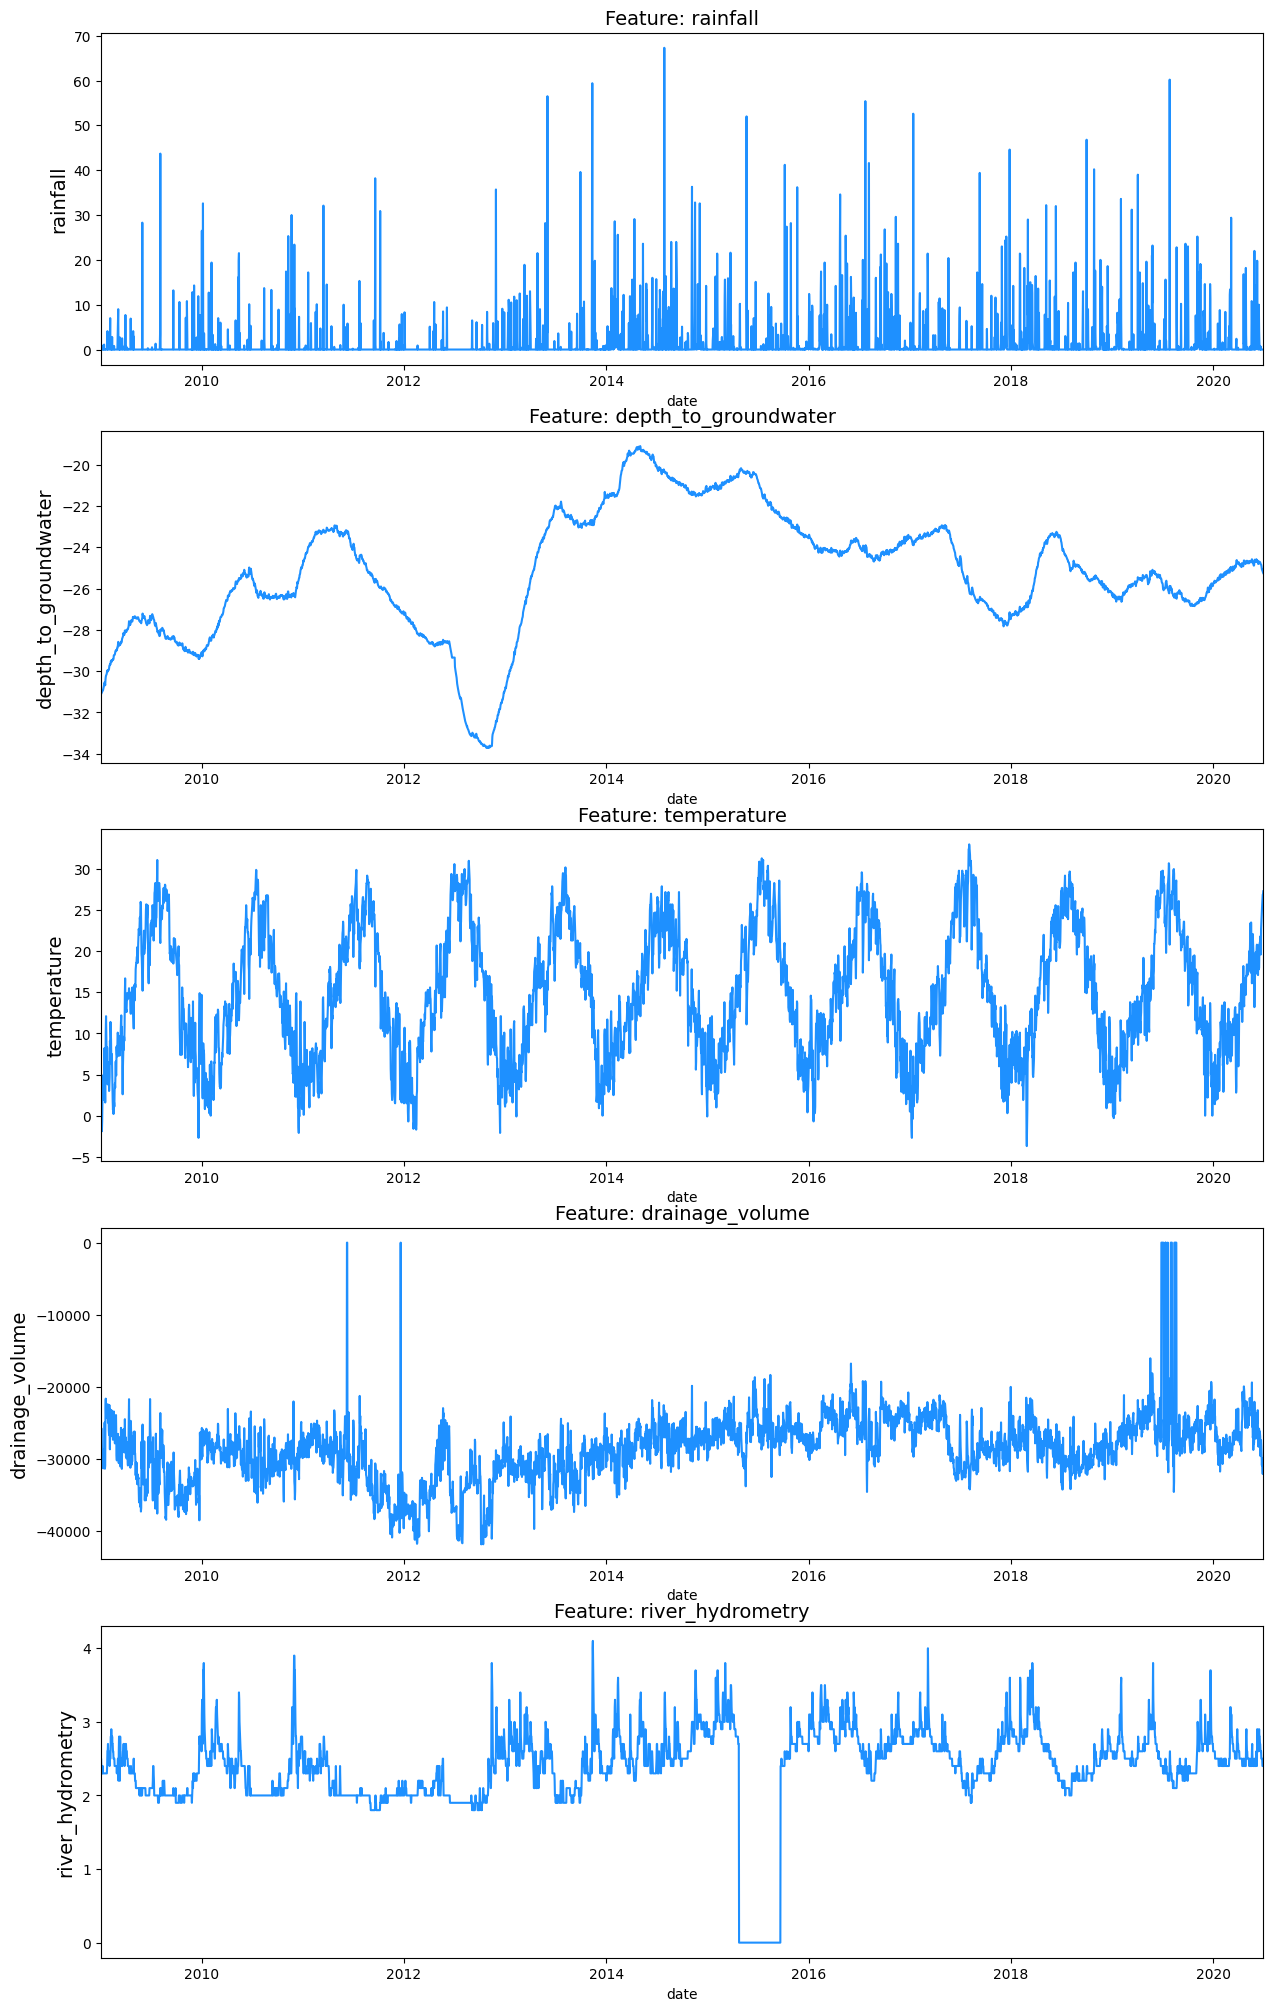

In [7]:

# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])     

## 2. Data Preprocessing

Chronological Order and Equidistant Timestamps
The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [8]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [9]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

### 2.1 Handle Missing values

As we can see, the dataset has some null values.

Furthermore, plotting the time series reveals that there seem to be some zero values that seems to be nulls for `drainage_volume`, and `river_hydrometry`. We will have to clean them by replacing them by nan values and filling them afterwards.

In [10]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

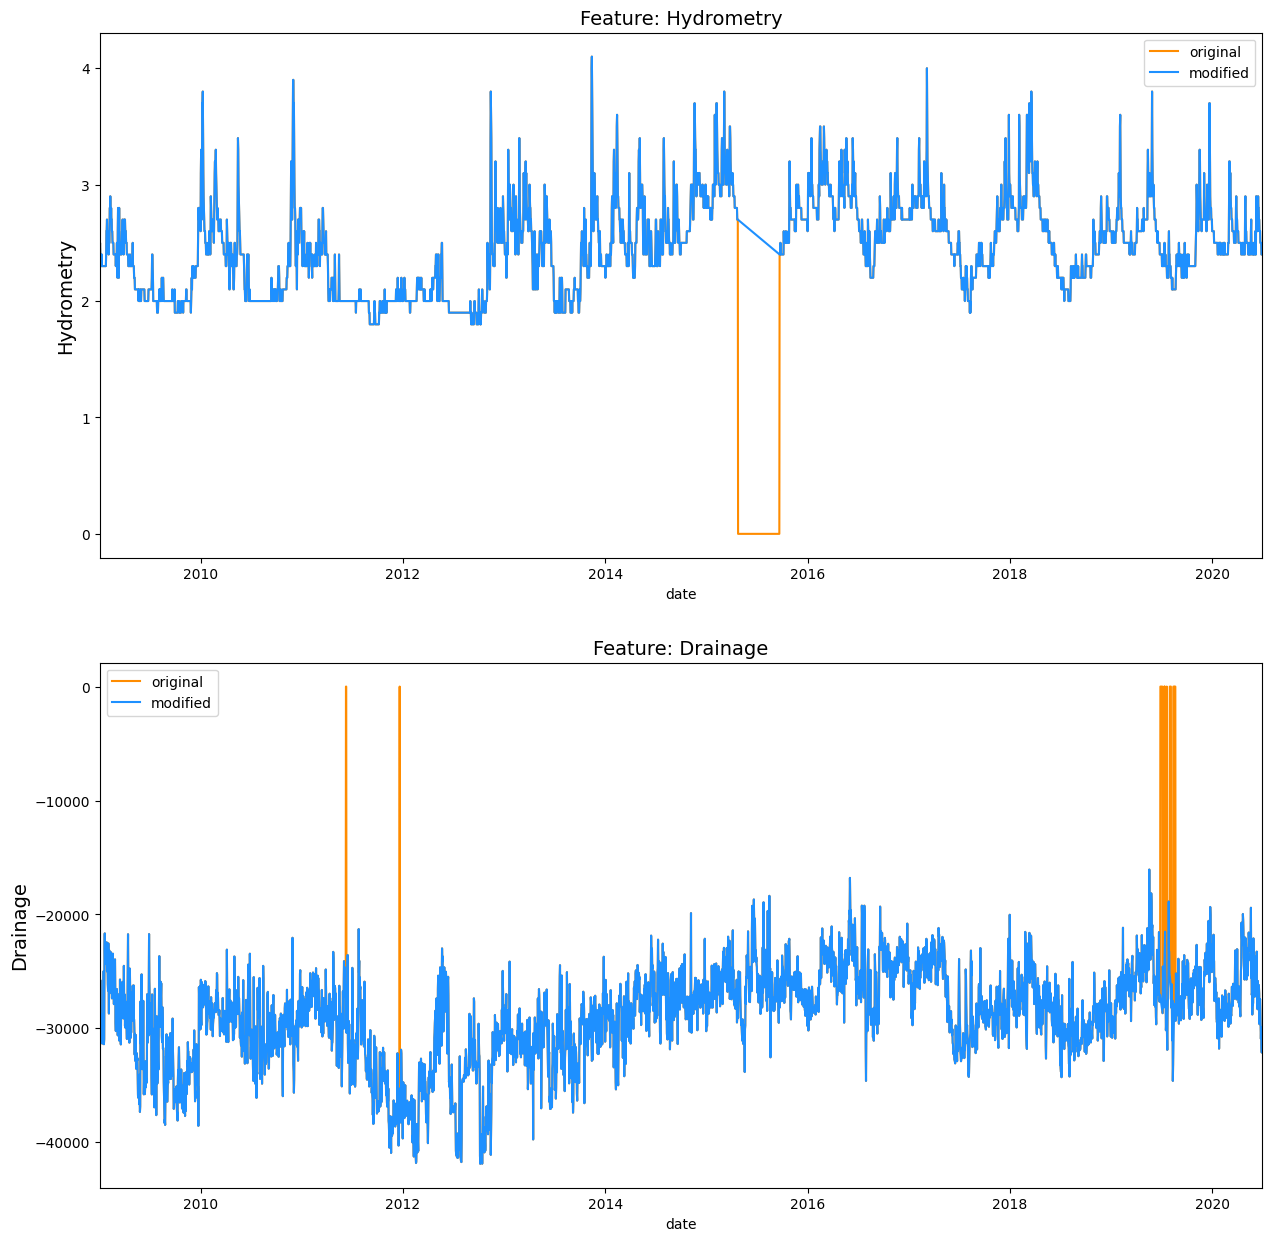

In [11]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

So now we have to fix missing values. Lets take a look of these cases and explore what can we do with them.

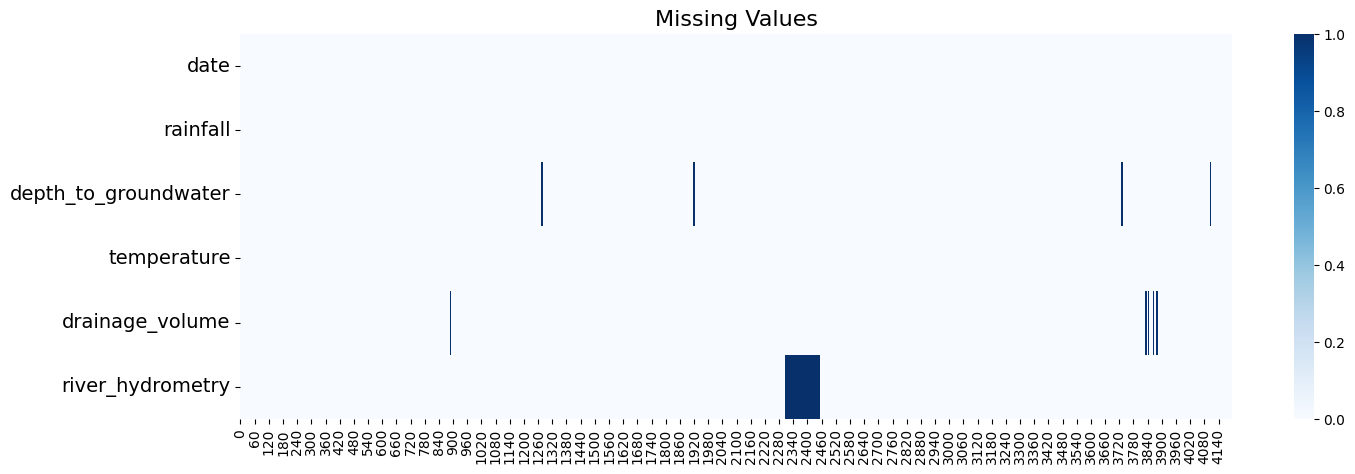

In [12]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Missing Values, how to handle

Option 1: Fill NaN with Outlier or Zero
In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

Option 2: Fill NaN with Mean Value
Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

Option 3: Fill NaN with Last Value with .ffill()
Filling NaNs with the last value could be bit better.

Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()
Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighbouring value

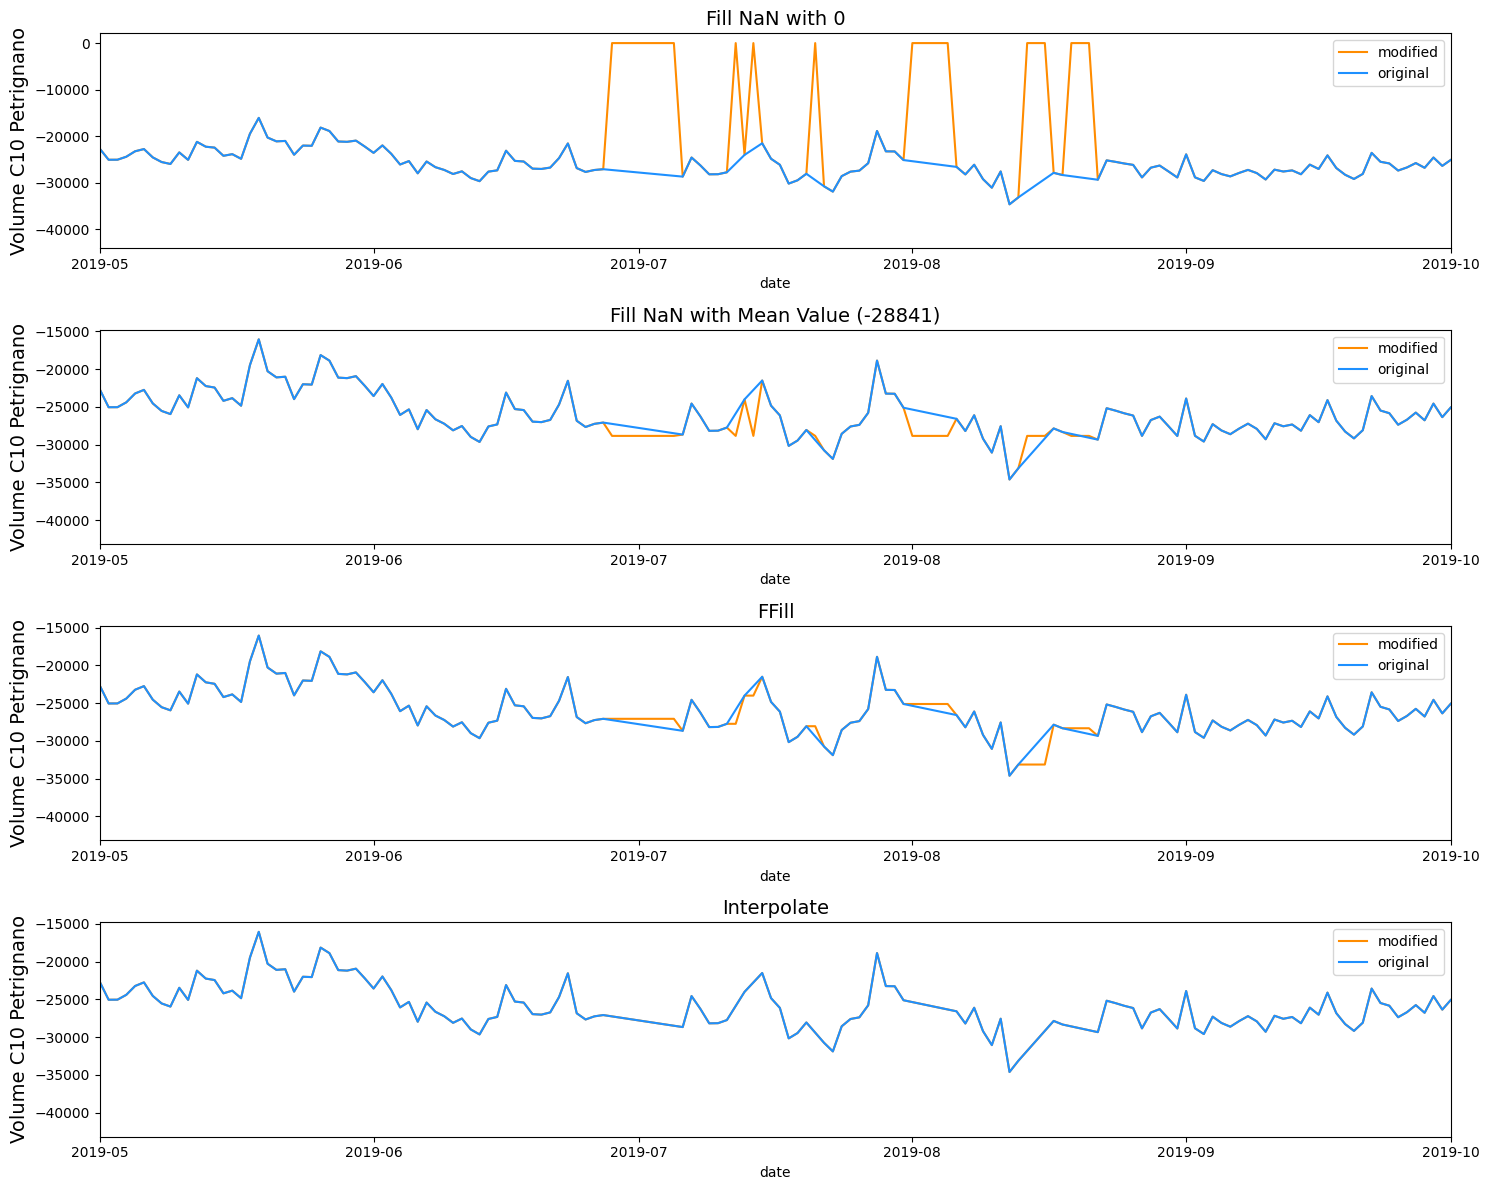

In [13]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

As we can see, the best option in this case,`interpolate` seems to best option!

So, lets interpolate missing values.

In [14]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

### 2.2 Smoothing data / Resampling

Resampling can provide additional information on the data. There are two types of resampling:

Upsampling is when the frequency of samples is increased (e.g. days to hours)

Downsampling is when the frequency of samples is decreased (e.g. days to weeks)

In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

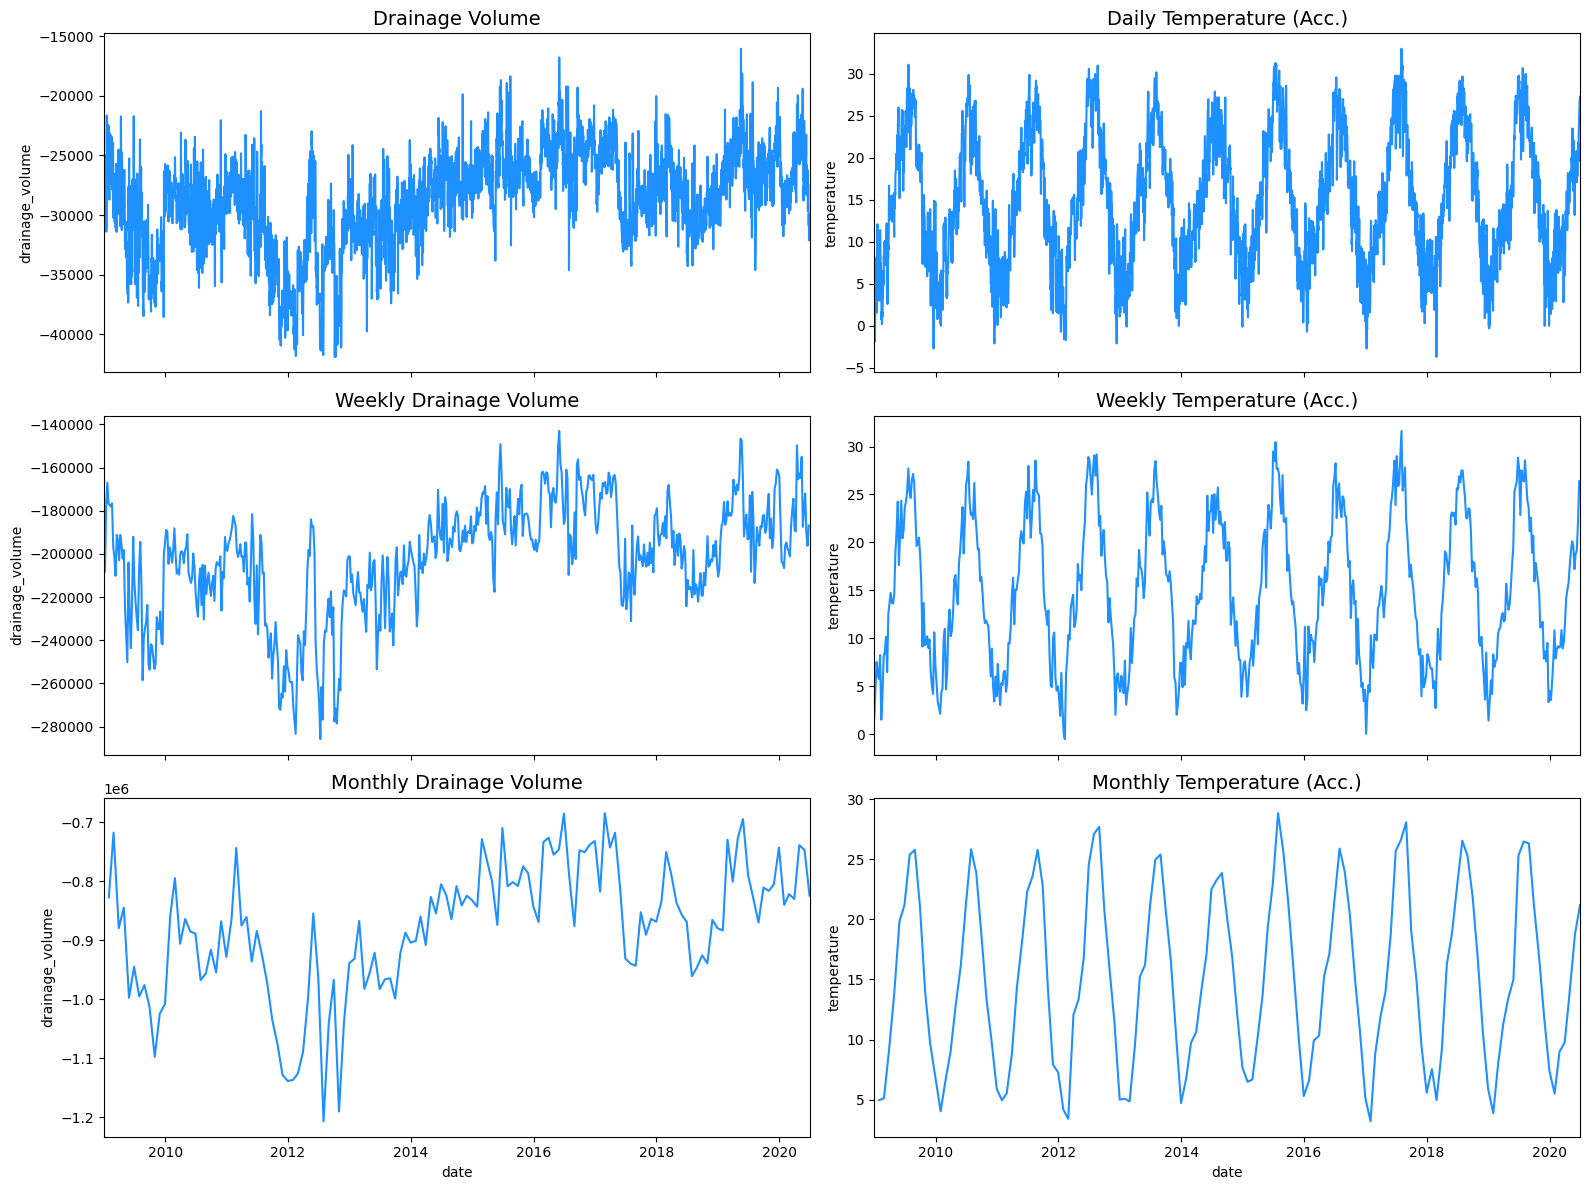

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

# Plotting Drainage Volume
sns.lineplot(x='date', y='drainage_volume', data=df, color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

# Resample Drainage Volume Weekly
resampled_df = df[['date', 'drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x='date', y='drainage_volume', data=resampled_df, color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

# Resample Drainage Volume Monthly
resampled_df = df[['date', 'drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x='date', y='drainage_volume', data=resampled_df, color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Plotting Temperature
sns.lineplot(x='date', y='temperature', data=df, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

# Resample Temperature Weekly
resampled_df = df[['date', 'temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x='date', y='temperature', data=resampled_df, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

# Resample Temperature Monthly
resampled_df = df[['date', 'temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x='date', y='temperature', data=resampled_df, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [16]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

### 2.3 Stationarity

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

constant mean and mean is not time-dependent
constant variance and variance is not time-dependent
constant covariance and covariance is not time-dependent

The check for stationarity can be done via three different approaches:

visually: plot time series and check for trends or seasonality

basic statistics: split time series and compare the mean and variance of each partition

statistical test: Augmented Dickey Fuller test

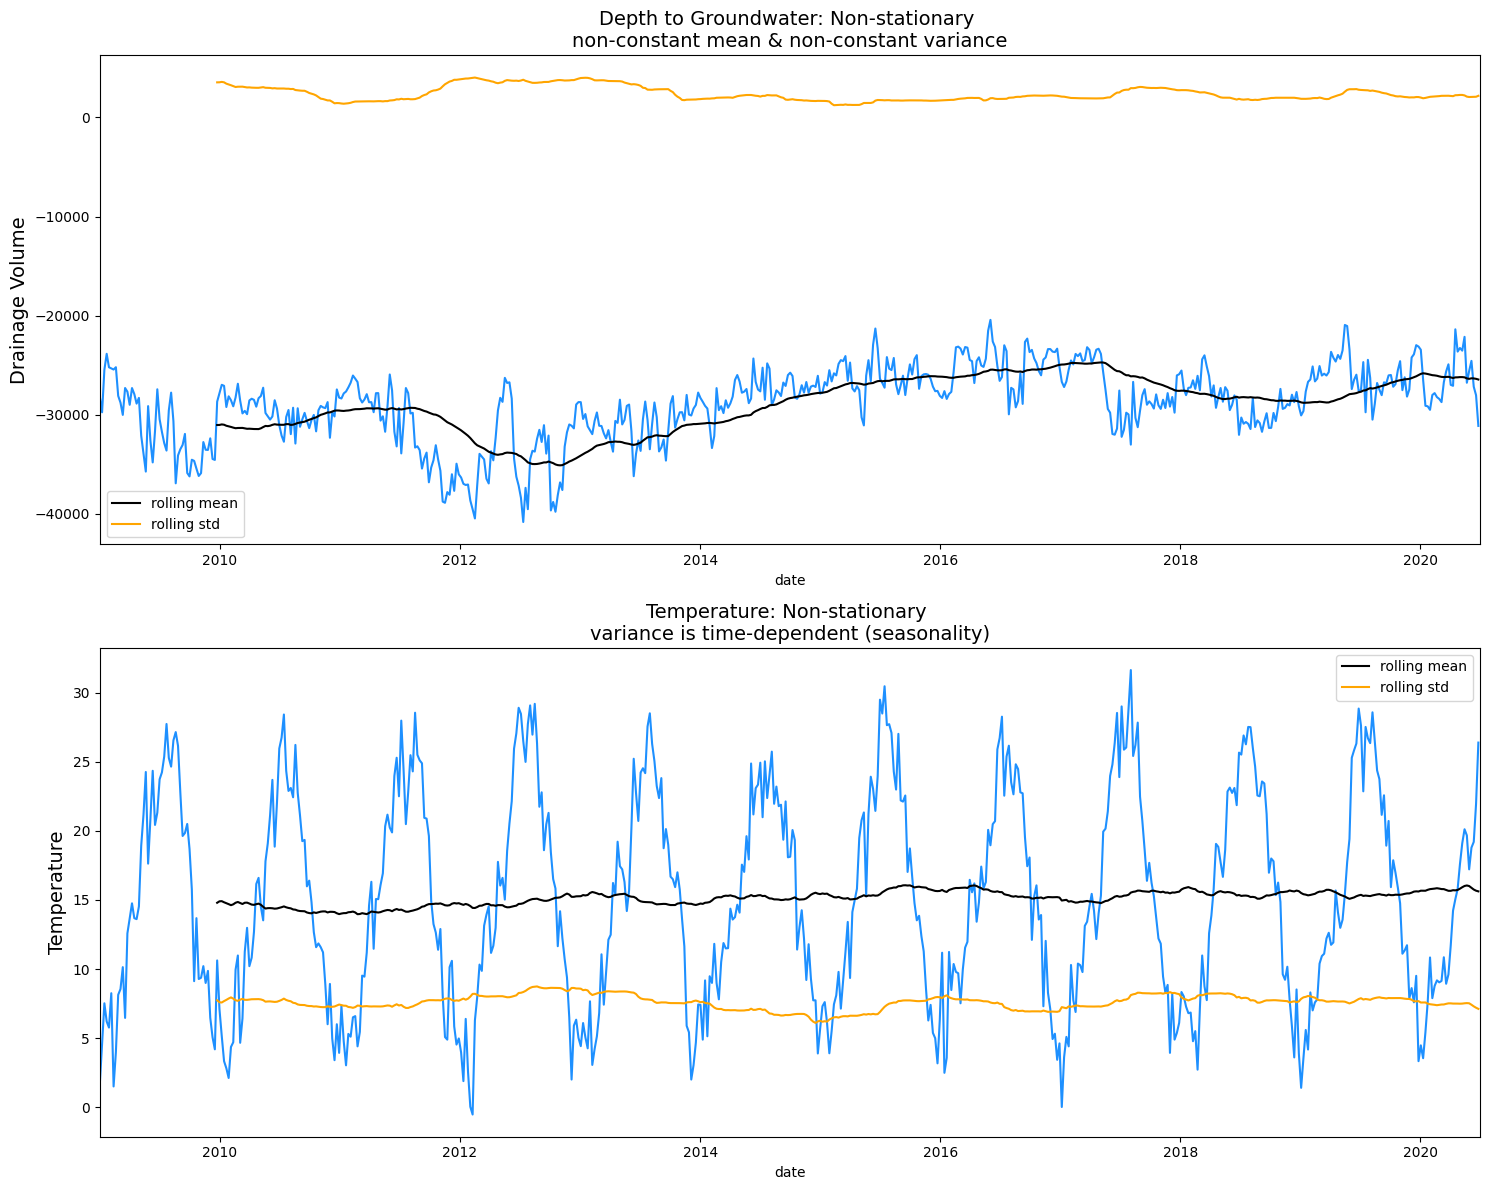

In [17]:
# A year has 52 weeks (52 weeks * 7 days per week) approx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In this visual check, we can see that the features don't have constant mean and std, but they are close to it.


#### Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

$Y_t=\alpha Y_{t-1}+\beta X_e+\epsilon$

where $Y_t$ is value of the time series at time ‘t’ and $X_e$ is an exogenous variable .

#### The presence of a unit root means the time series is non-stationary.

### 2.3.1 Augmented Dickey-Fuller (ADF)

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis ($H_0$): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis ($H_1$): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.8802016493166613,
 0.04769919092020876,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

Now, we are going to check for each variable:

The p-value is less than 0.05

Check the range of the ADF statistic compared with critical_values

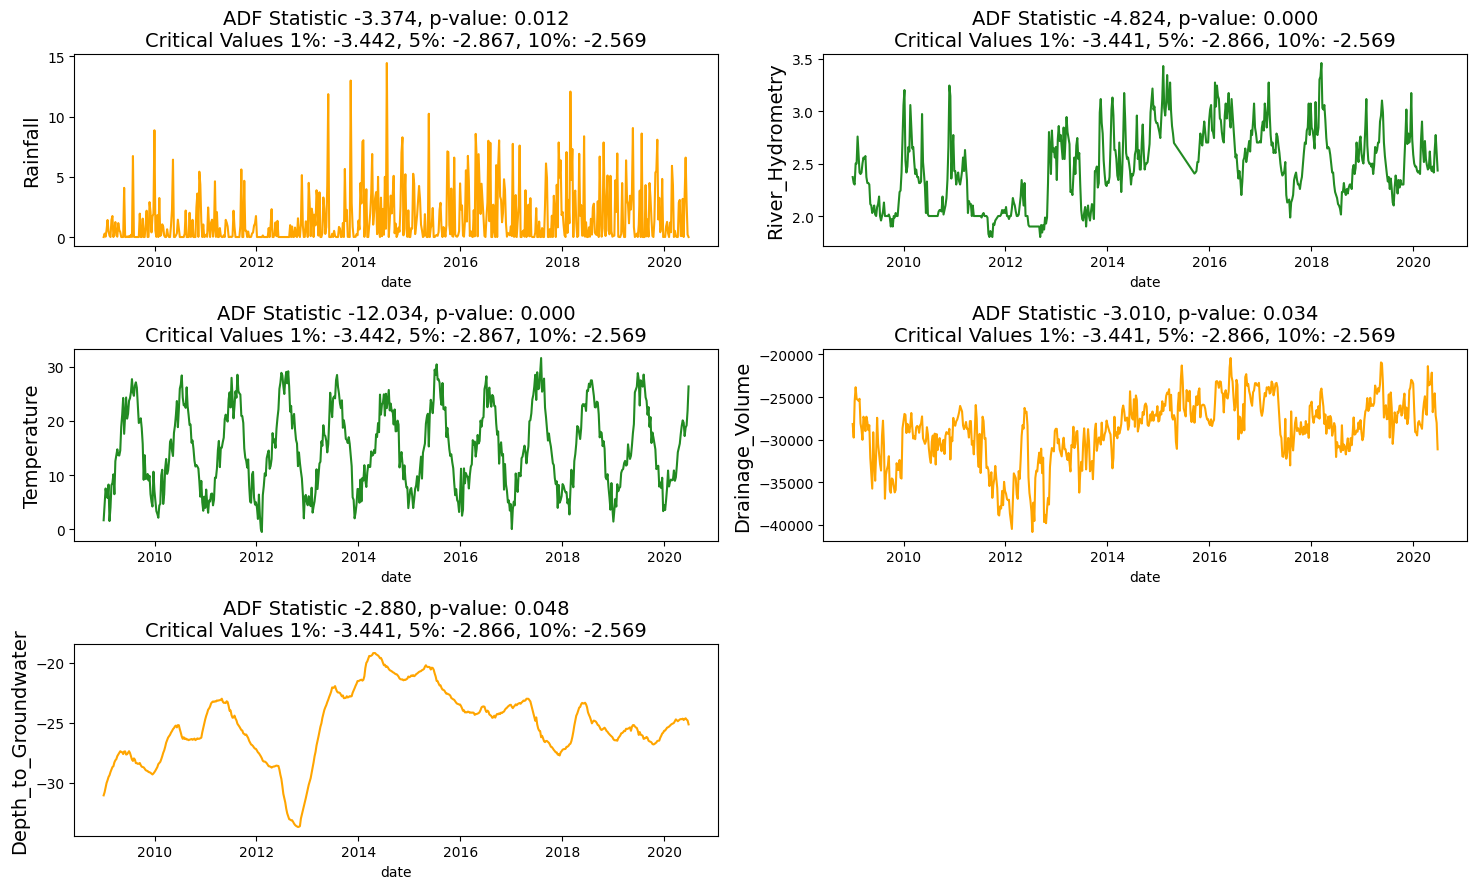

In [19]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

* Transformation: e.g. log or square root to stabilize non-constant variance

* Differencing: subtracts the current value from the previous

### 2.3.2 Transforming

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

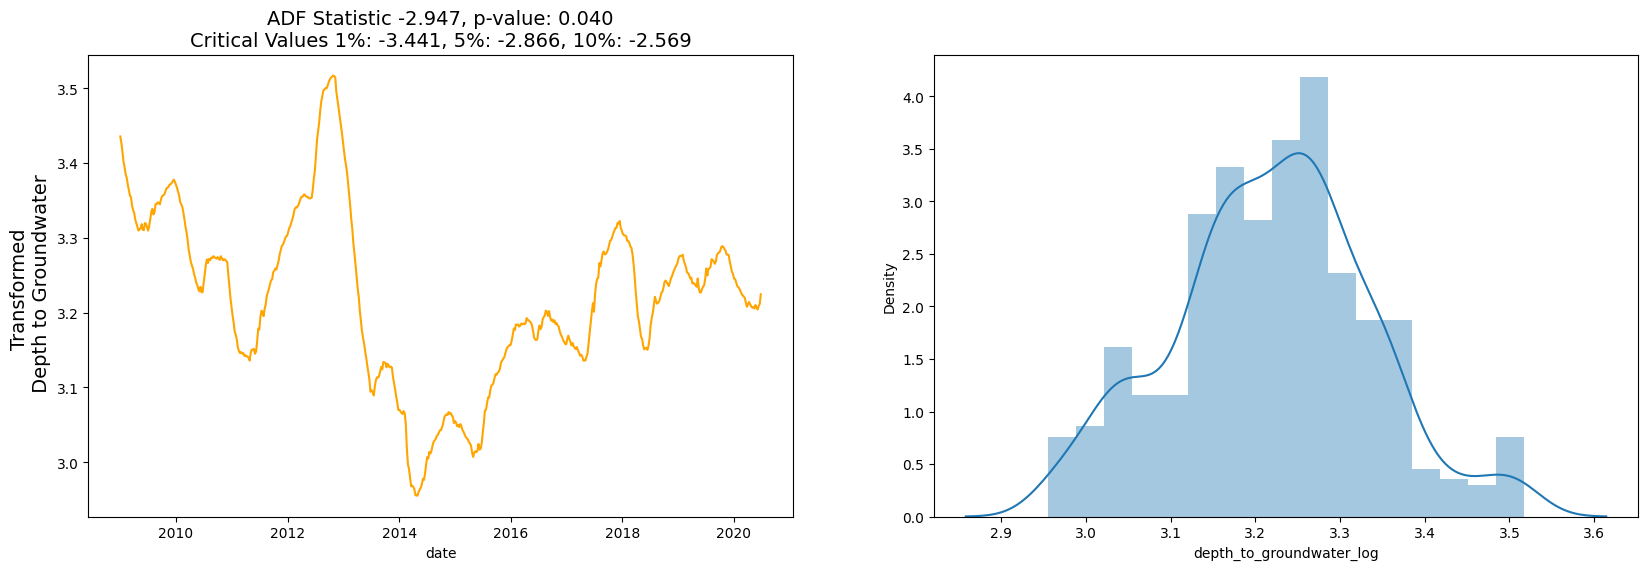

In [20]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

Differencing can be done in different orders:

First order differencing: linear trends with  $z_i=y_i-y_{i-1}$

Second-order differencing: quadratic trends with $z_i=(y_i-y_{i-1})-(y_{i-1}-y_{i-2})$
 
and so on...

### 2.3.3 Differencing

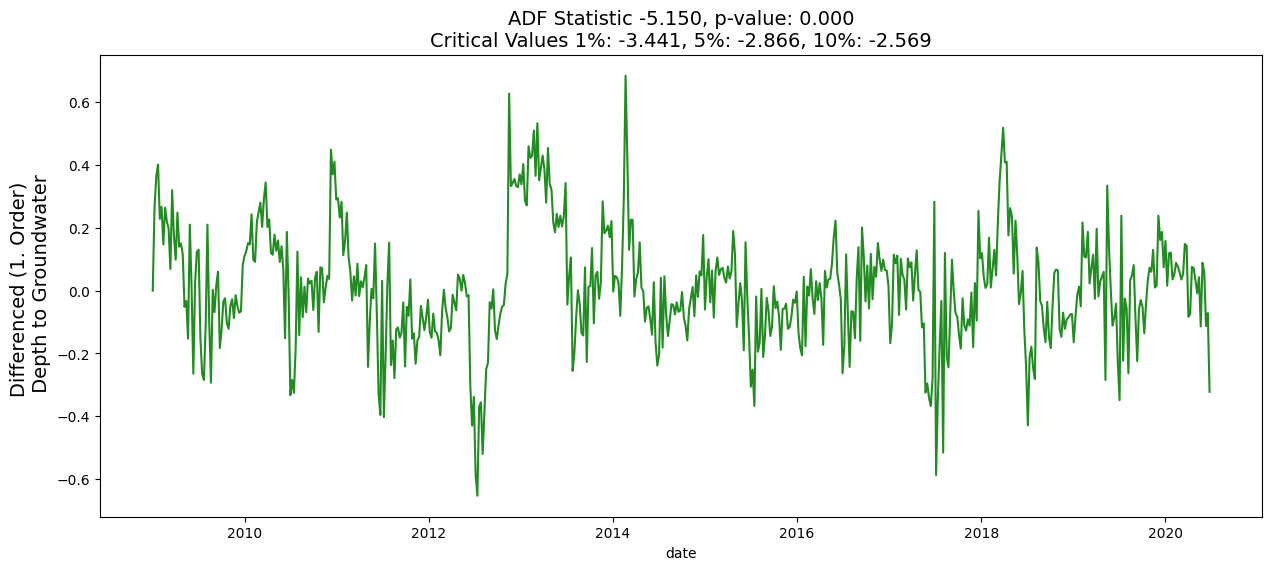

In [21]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

## 3. Feature Engineering

In [22]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).isocalendar().week
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,<NA>,1,1
1,2009-01-08,2009,1,8,8,<NA>,1,1
2,2009-01-15,2009,1,15,15,<NA>,1,1
3,2009-01-22,2009,1,22,22,<NA>,1,1
4,2009-01-29,2009,1,29,29,<NA>,1,1


### 3.1 Encoding cyclical features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

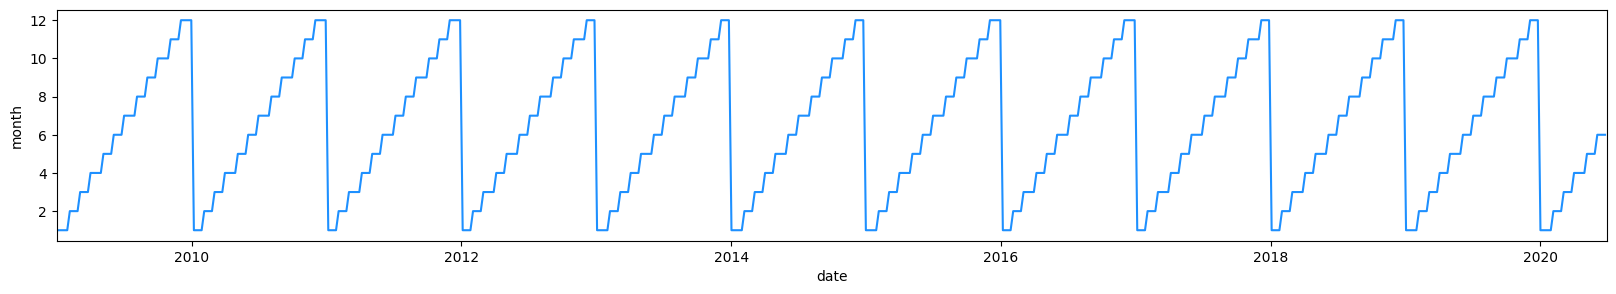

In [23]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

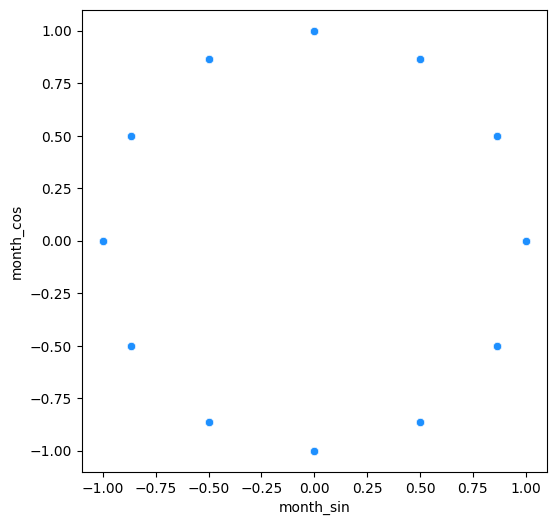

In [24]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

### 3.2 Time Series Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* Level: The average value in the series.

* Trend: The increasing or decreasing value in the series.

* Seasonality: The repeating short-term cycle in the series.

* Noise: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

Additive: $y(t)=Level+Trend+Seasonality+Noise$

Multiplicative: $y(t)=Level \times Trend \times Seasonality \times Noise$
 
In this case we are going to use function `seasonal_decompose()` from the `statsmodels` library.

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

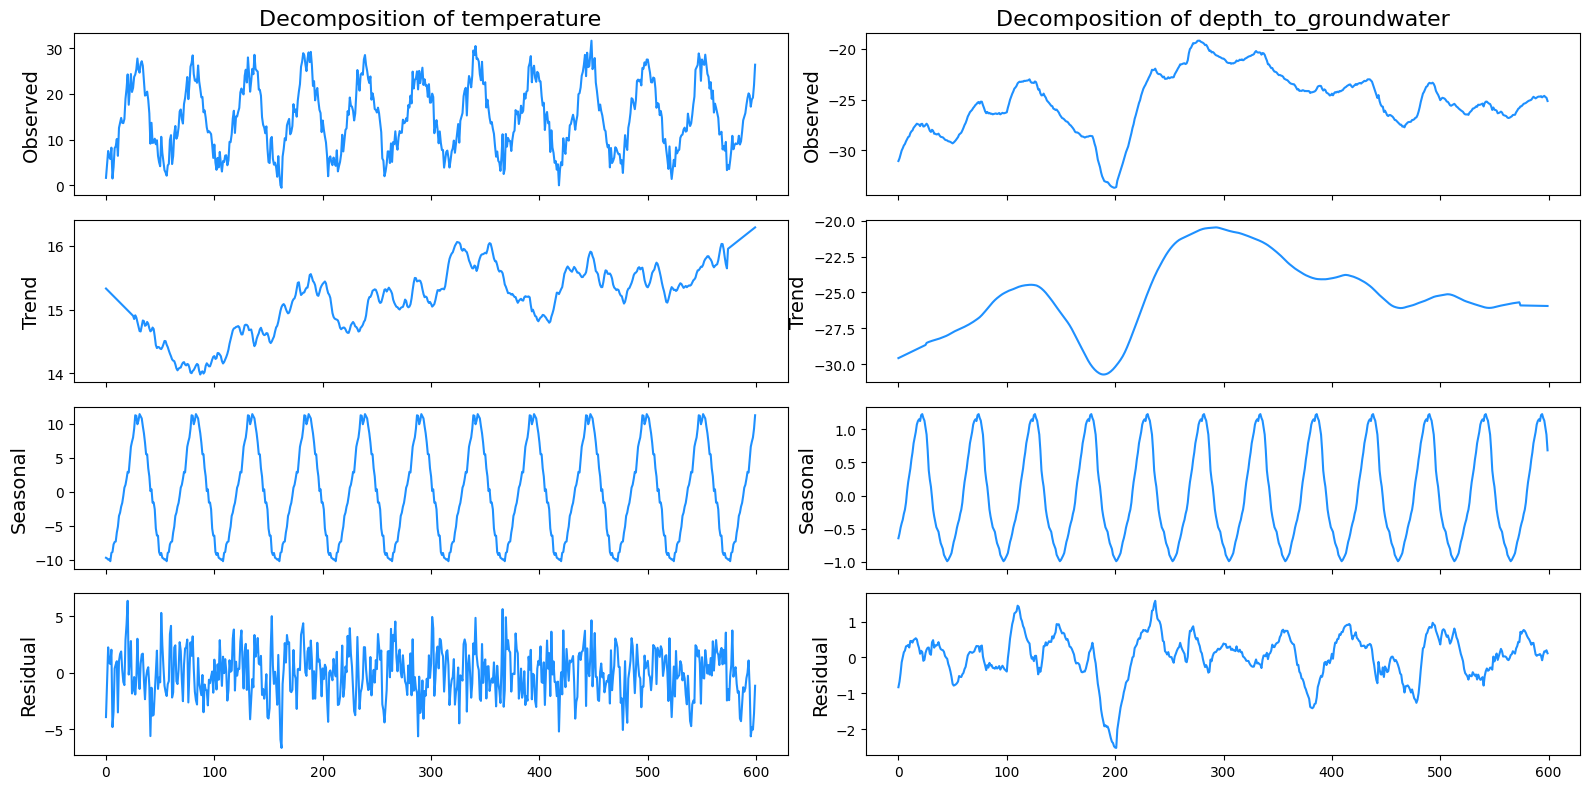

In [26]:

fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16, 8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):

    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0, i].set_title('Decomposition of {}'.format(column), fontsize=16)
    df[column].plot(ax=ax[0, i], legend=False, color='dodgerblue')  # Plot the observed data
    ax[0, i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1, i], legend=False, color='dodgerblue')
    ax[1, i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2, i], legend=False, color='dodgerblue')
    ax[2, i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3, i], legend=False, color='dodgerblue')
    ax[3, i].set_ylabel('Residual', fontsize=14)

plt.tight_layout()
plt.show()


### 3.3 Lag

We want to calculate each variable with a `shift()` (lag) to compare the correlationwith the other variables.

In [27]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

## 4. Exploratory Data Analysis

Now, we are going to plot the data and try to extract some knowledge.

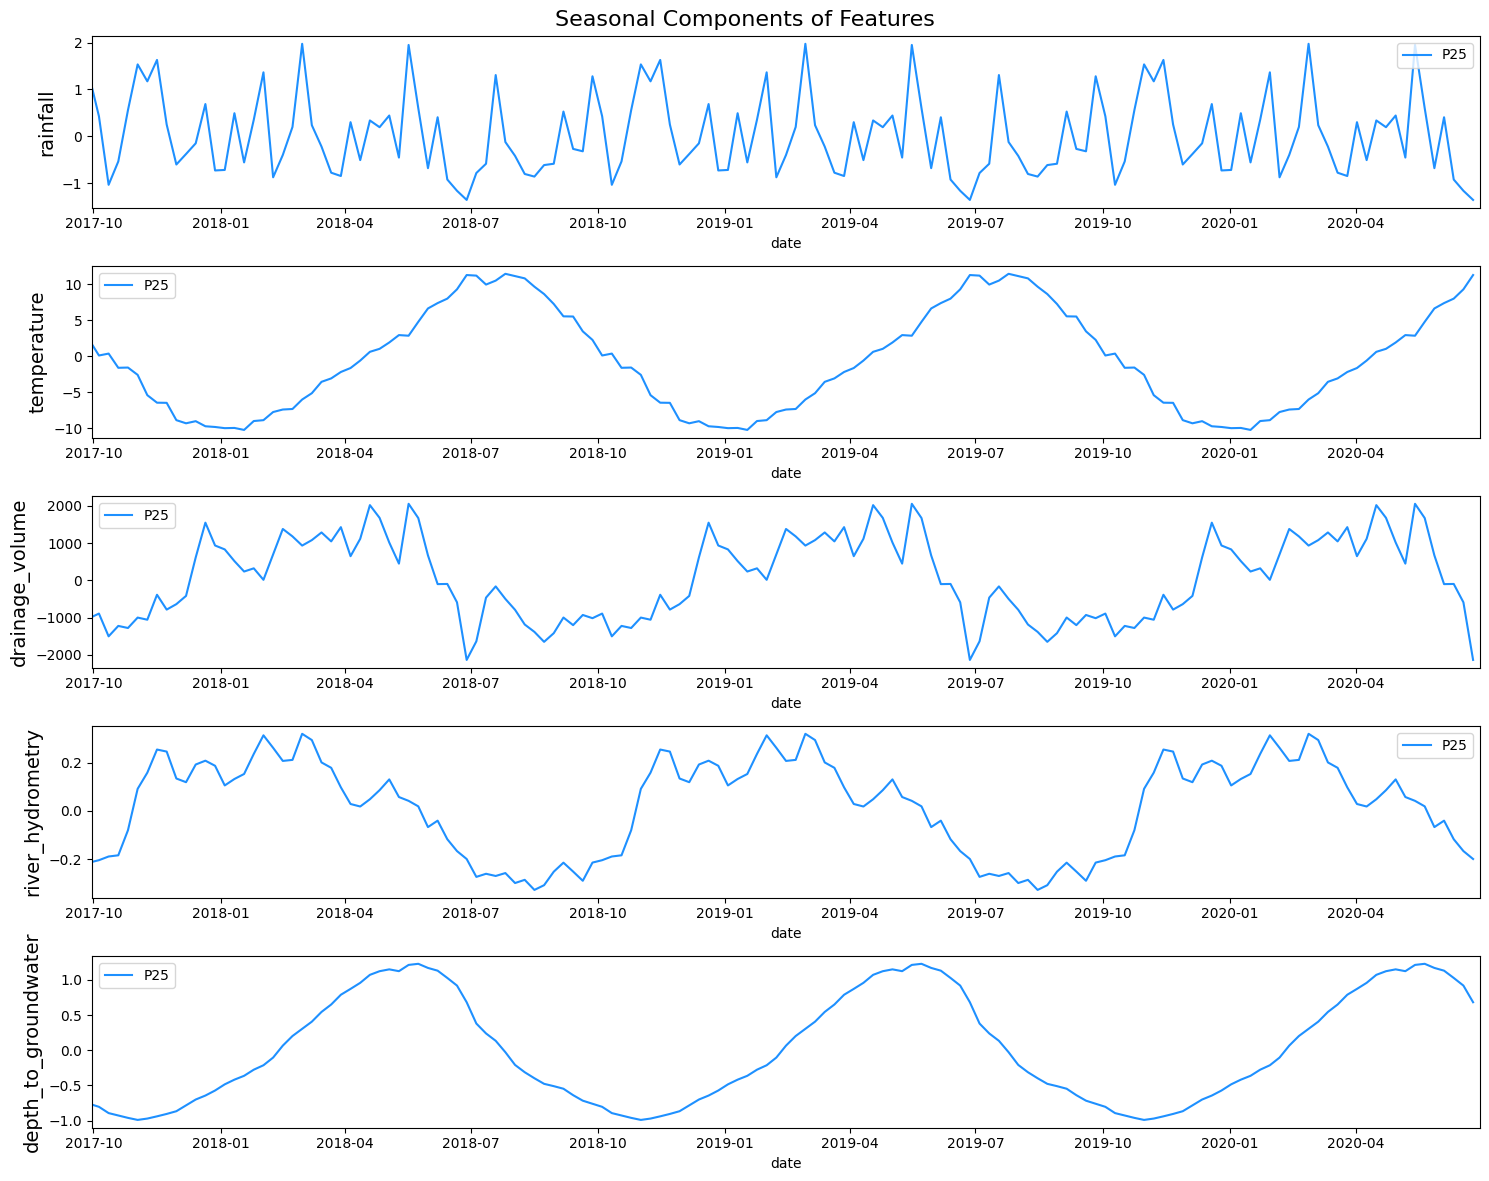

In [28]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

As we can see:

* depth_to_groundwater: reaches its maximum around May/June and its minimum around November

* temperature: reaches its maxmium around August and its minimum around January

* drainage_volume: reaches its minimum around July.

* river_hydrometry: reaches its maximum around February/March and its minimum around September

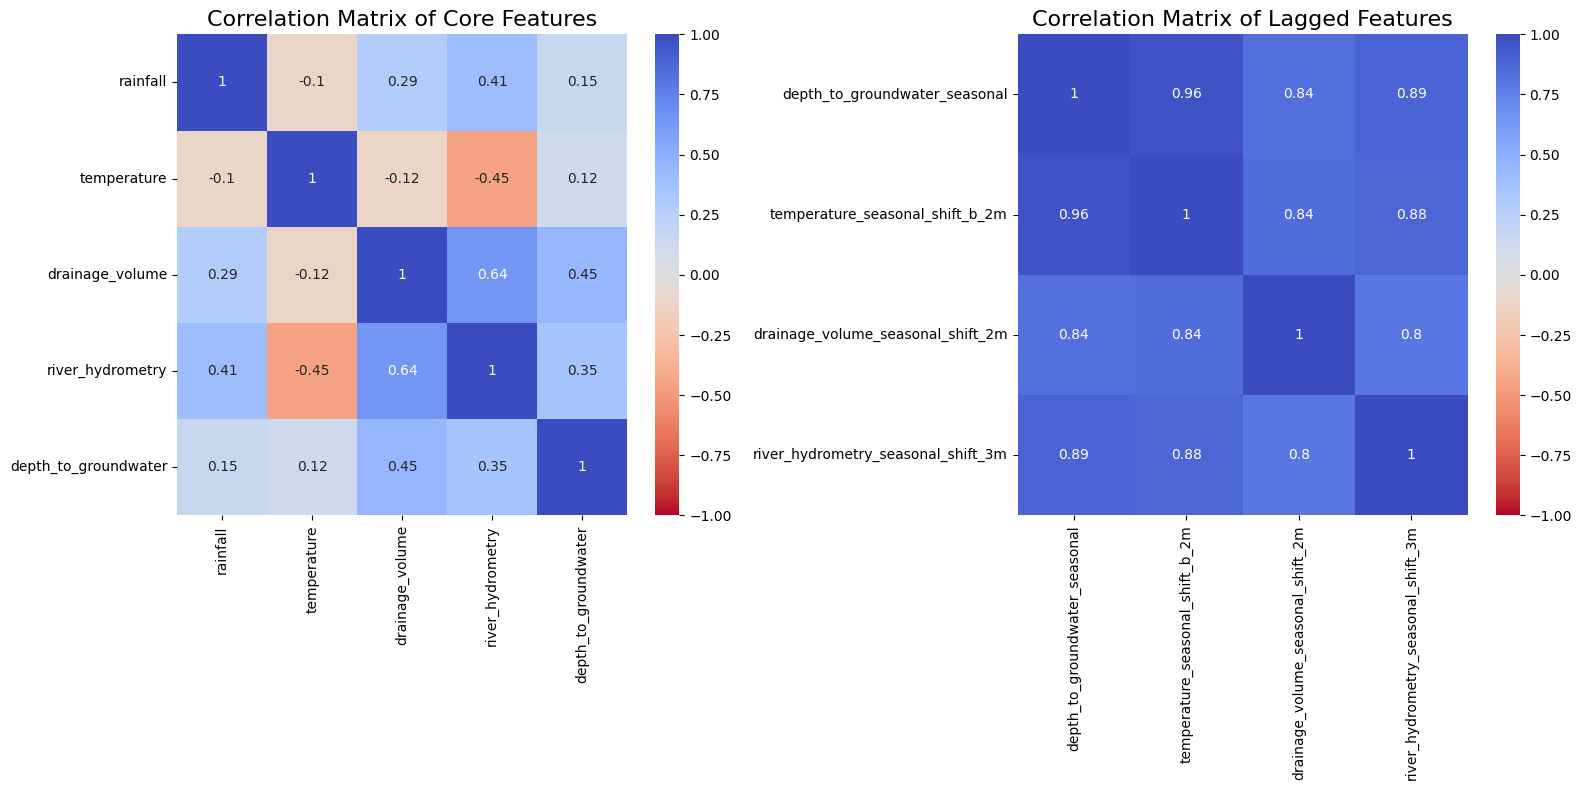

In [29]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

As we can see, the features are higher correlated in the case of shifted features (lagged ones) than the original ones.

### 4.1 Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. 

By looking at the `autocorrelation function (ACF)` and `partial autocorrelation (PACF)` plots of the differenced series, we can tentatively identify the numbers of AR and/or MA terms that are needed.

* Autocorrelation Function (ACF): 

P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter

* Partial Autocorrelation Function (PACF):

D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

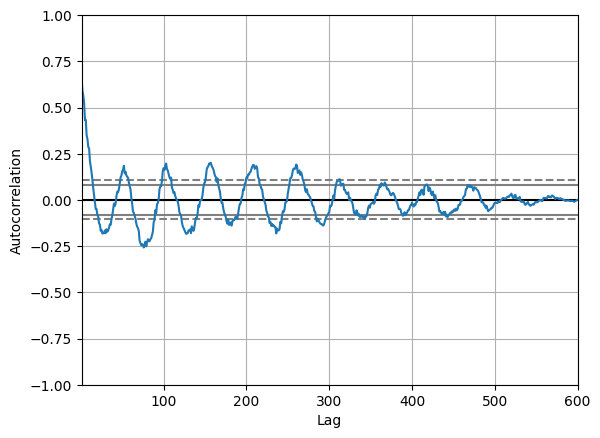

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

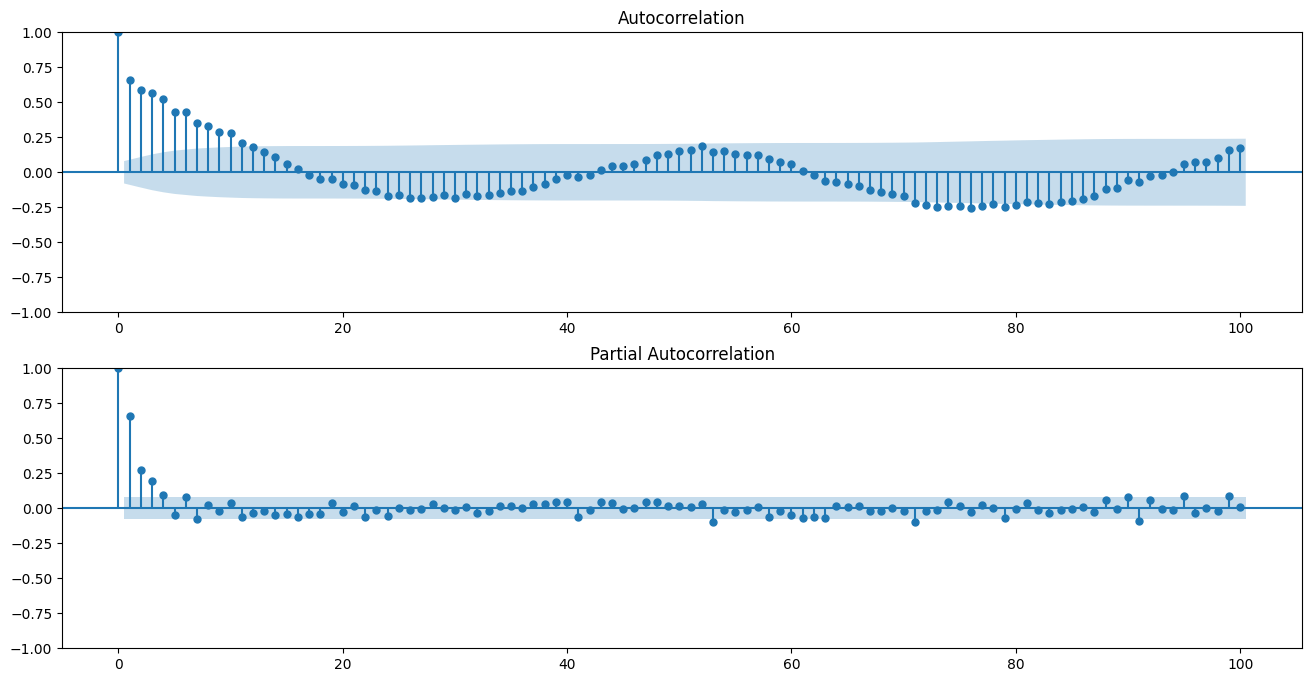

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

## 5. Modelling

Time series can be either univariate or multivariate:

Univariate time series only has a single time-dependent variable.

Multivariate time series have a multiple time-dependent variable.

But, first of all we are going to see how does cross-validation technique works in TimeSeries Analysis.

In [32]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

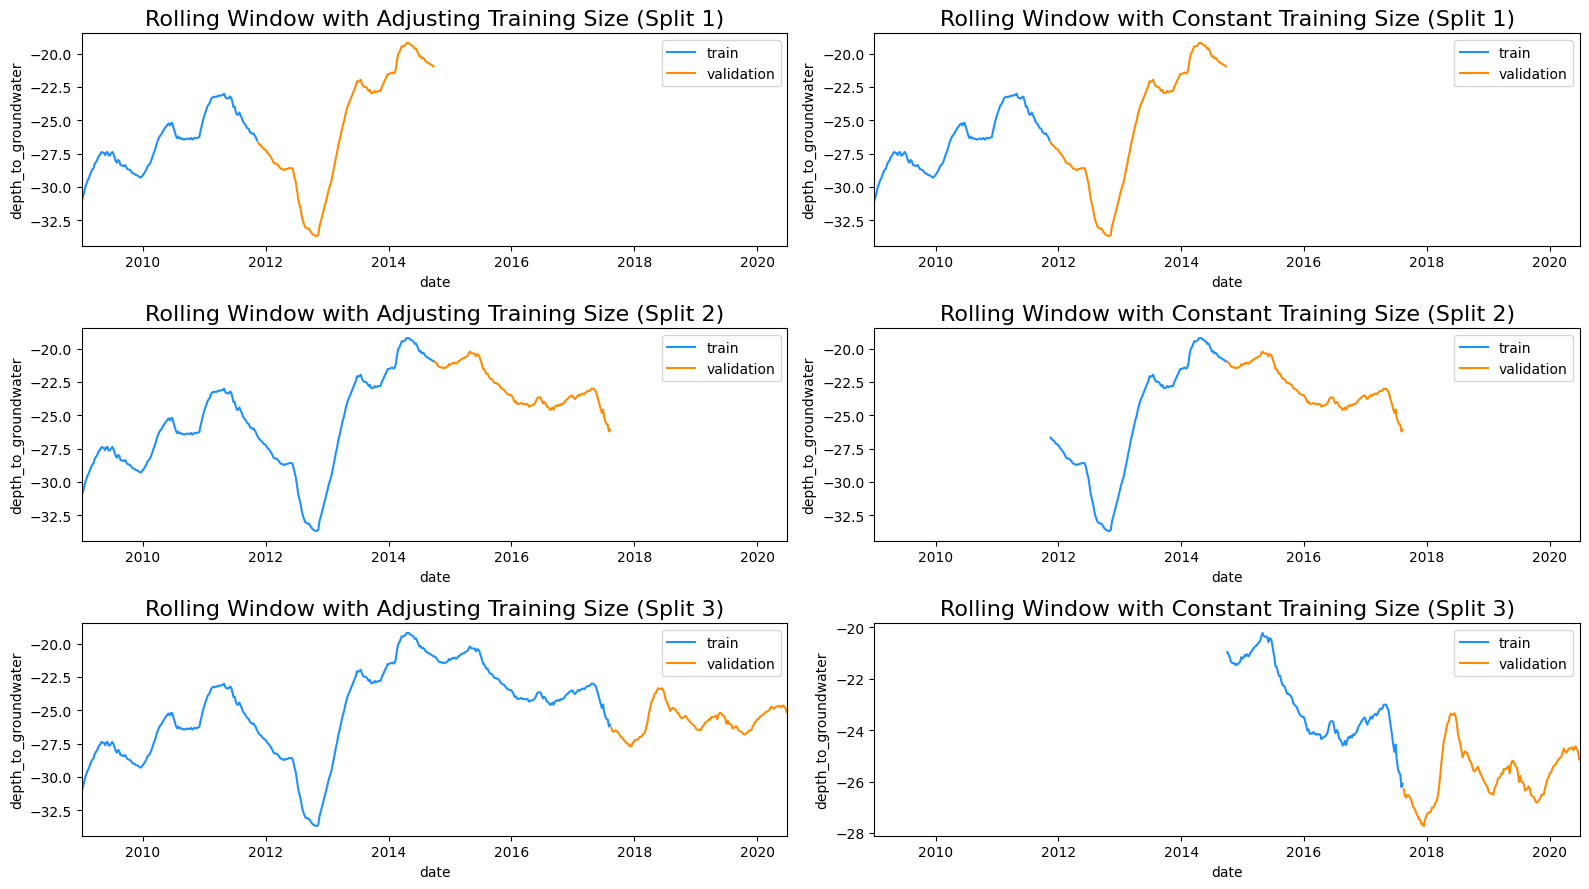

In [33]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    
    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.

### 5.1 Models for Univariate Time Series

First of all, we are going to analize univariate TimeSeries forecasting.

* Univariate time series: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [34]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


### 5.1.1 ARIMA

The first model that i want to try is ARIMA.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the autocorrelations in the data. The model assumes that the time-series is stationary. It consists of three main parts:

* Auto-Regressive (AR) filter (long term):

$y_t=c+\alpha_1 y_{t-1}+\dots + \alpha_p y_{t-p}+\epsilon_t -> p$

* Integration filter (stochastic trend):

-> d

* Moving Average (MA) filter (short term):

$y_t=c+\epsilon_t+\beta_1 \epsilon_{t-1}+\dots + \beta_q \epsilon_{t-q} -> q$


ARIMA: $y_t=c+\alpha_1 y_{t-1}+\dots + \alpha_p y_{t-p}+\epsilon_t+ \beta_1 \epsilon_{t-1}+\dots + \beta_q \epsilon_{t-q}$

ARIMA( p, d, q)

* p: Lag order (reference PACF in Autocorrelation Analysis)

* d: Degree of differencing. (reference Differencing in Stationarity)

* q: Order of moving average (check out ACF in Autocorrelation Analysis)

Steps to analyze ARIMA

Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.

Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this

Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).

Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [35]:
import statsmodels.api as sm

# Fit model
model = sm.tsa.arima.ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(steps=90)

# Calculate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))


RMSE: 1.4025336271849616


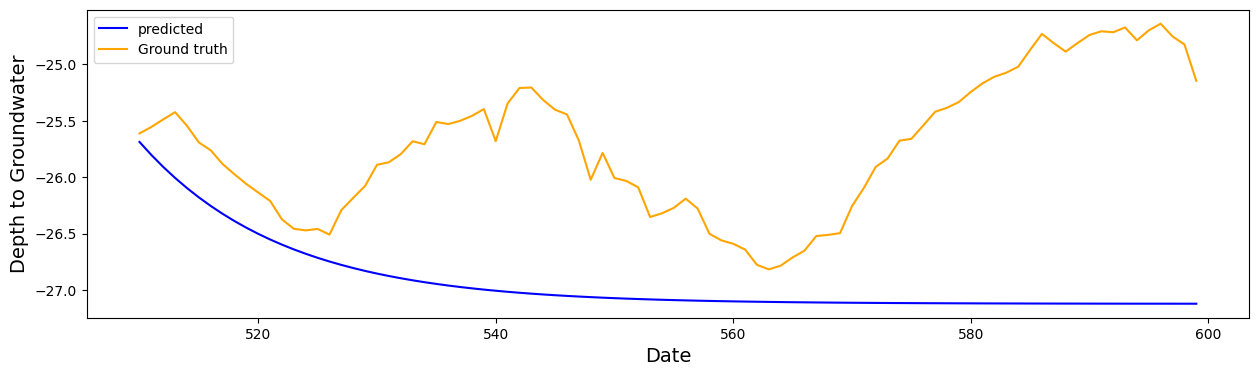

In [36]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

### 5.1.2 Auto ARIMA

In [37]:
#!pip install pmdarima

In [38]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]          

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (1,1,1) is the best configuration for (p,d,q).

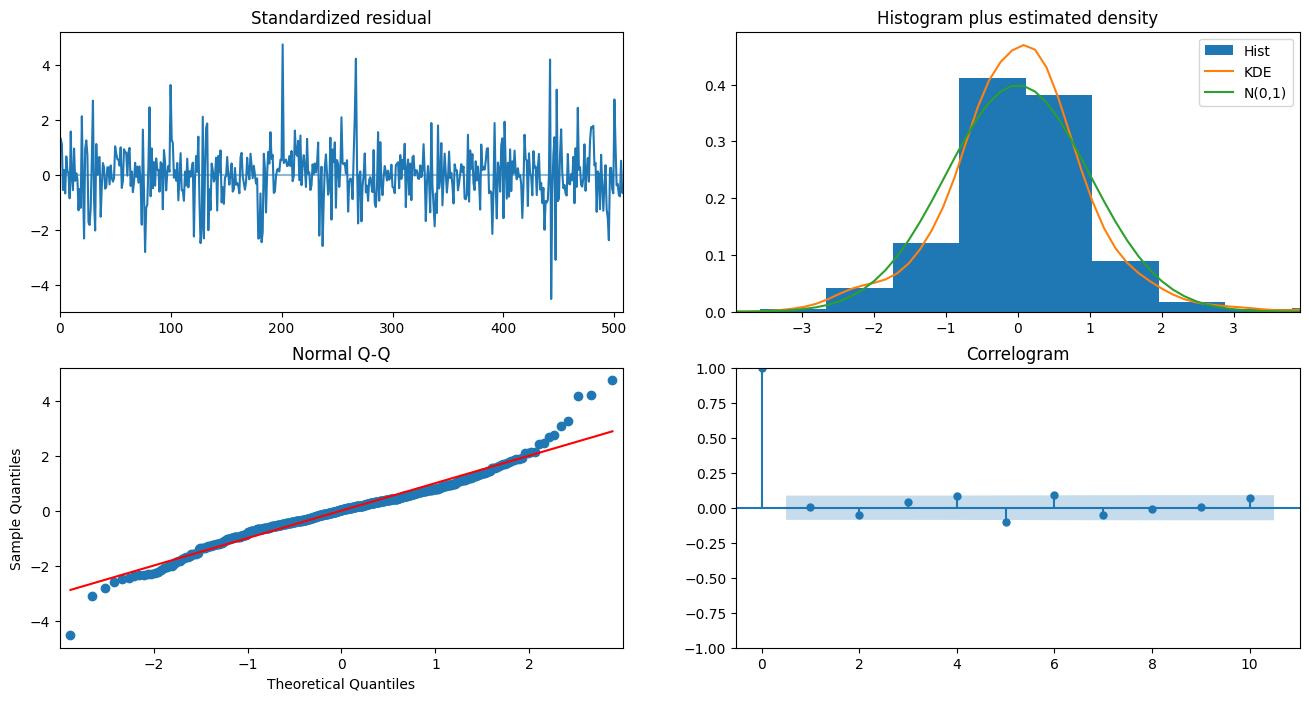

In [39]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

* Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

* Top Right: The density plot suggest normal distribution with mean zero.

* Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

* Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

### 5.1.3 LSTM

We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

* Create the dataset, ensure all data is float.
 
* Normalize the features.
 
* Split into training and test sets.
 
* Convert an array of values into a dataset matrix.
 
* Reshape into X=t and Y=t+1.
 
* Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [40]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [41]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 4s 3ms/step - loss: 0.0141 - val_loss: 0.0015
Epoch 2/5
406/406 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 7.5889e-04
Epoch 3/5
406/406 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 5.8457e-04
Epoch 4/5
406/406 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 8.7095e-04
Epoch 5/5
406/406 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            92672     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
           

In [43]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

3/3 [==============================] - 0s 3ms/step
RMSE: 0.5217955042522848
